# Strikeout % Prediction for 2024 Season

This notebook uses historical player data to train a Ridge Regression model for predicting strikeout percentage (K%) in the 2024 MLB season.

In [23]:
using Pkg
Pkg.activate("k_model_env")

using CSV, DataFrames, StatsPlots
using MLJ
import MLJLinearModels: RidgeRegressor

  Activating project at `~/git/QuantAnalysisAssets/phillies_takehome/k_model_env`


In [5]:
df = CSV.read("k.csv", DataFrame)
rename!(df, Symbol("K%") => :K)

sort!(df, [:MLBAMID, :Season])
df[!, :K_prev] = Vector{Union{Missing, Float64}}(missing, nrow(df))
df[!, :TBF_prev] = Vector{Union{Missing, Int64}}(missing, nrow(df))

for g in groupby(df, :MLBAMID)
    indices = parentindices(g)[1]  # gives original indices from parent DataFrame
    for i in 2:length(indices)
        curr = indices[i]
        prev = indices[i - 1]
        df.K_prev[curr] = df.K[prev]
        df.TBF_prev[curr] = df.TBF[prev]
    end
end

df_model = dropmissing(df, [:K_prev, :TBF_prev])


Row,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K,K_prev,TBF_prev
,Int64,Int64,String31,String7,Int64,Int64,Int64,Float64,Float64,Int64
1,425794,2233,Adam Wainwright,STL,40,2022,803,0.178082,0.210145,828
2,425794,2233,Adam Wainwright,STL,41,2023,484,0.113636,0.178082,803
3,425844,1943,Zack Greinke,KCR,38,2022,585,0.124786,0.172166,697
4,425844,1943,Zack Greinke,KCR,39,2023,593,0.163575,0.124786,585
5,434378,8700,Justin Verlander,- - -,40,2023,669,0.215247,0.277778,666
6,434378,8700,Justin Verlander,HOU,41,2024,396,0.186869,0.215247,669
7,445276,3096,Kenley Jansen,ATL,34,2022,260,0.326923,0.309353,278
8,445276,3096,Kenley Jansen,BOS,35,2023,188,0.276596,0.326923,260
9,445276,3096,Kenley Jansen,BOS,36,2024,218,0.284404,0.276596,188


In [ ]:
X_df = select(df_model, [:K_prev, :TBF_prev, :Age])
y_vec = df_model.K

1029-element Vector{Float64}:
 0.17808219
 0.11363636
 0.12478632
 0.16357504
 0.21524664
 0.18686869
 0.32692308
 0.27659574
 0.28440367
 0.25342466
 ⋮
 0.22180451
 0.21398305
 0.17486339
 0.20353982
 0.24342105
 0.17445483
 0.2
 0.41767068
 0.19811321

In [7]:
model = RidgeRegressor(lambda=0.1)
mach = machine(model, X_df, y_vec)
fit!(mach)

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc MLJLinearModels.RidgeRegressor` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{Table{Union{AbstractVector{Continuous}, AbstractVector{Count}}}, AbstractVector{Continuous}}
│ 
│ fit_data_scitype(model) = Tuple{Table{<:AbstractVector{<:Continuous}}, AbstractVector{Continuous}}
└ @ MLJBase /Users/ryanwilliams/.julia/packages/MLJBase/7nGJF/src/machines.jl:2

trained Machine; caches model-specific representations of data
  model: RidgeRegressor(lambda = 0.1, …)
  args: 
    1:	Source @494 ⏎ Table{Union{AbstractVector{Continuous}, AbstractVector{Count}}}
    2:	Source @018 ⏎ AbstractVector{Continuous}


In [8]:
y_pred = MLJ.predict(mach, X_df)
df_model.K_pred = y_pred

1029-element Vector{Float64}:
 0.2134393530560294
 0.2137009682414009
 0.21814941077655386
 0.22157619640183632
 0.2211836383626375
 0.21974533381554037
 0.23791533766482928
 0.23885376852589277
 0.24063304958290307
 0.24247532262035867
 ⋮
 0.24314065030505766
 0.23424319250360262
 0.2391304372832572
 0.2183118032250431
 0.23161190021808456
 0.23742111138551664
 0.24079838727019648
 0.24379118088400922
 0.2414693906969745

In [25]:
r2 = rsq(y_pred, y_vec)
rmse = sqrt(mean((y_pred .- y_vec).^2))

println("R² Score: ", round(r2, digits=4))
println("RMSE: ", round(rmse, digits=4))

R² Score: 0.0449
RMSE: 0.0544


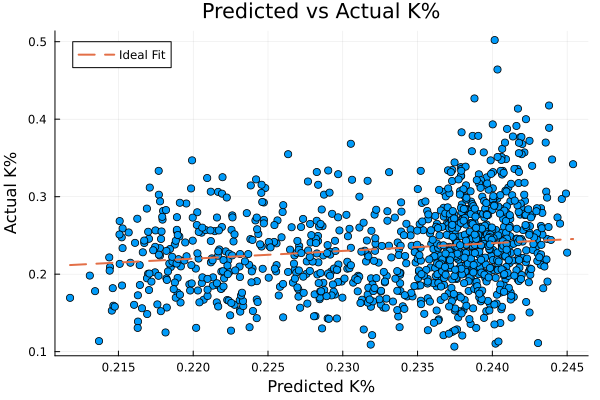

In [26]:
scatter(y_pred, y_vec, xlabel="Predicted K%", ylabel="Actual K%", title="Predicted vs Actual K%", label="")
plot!(identity, label="Ideal Fit", linewidth=2, linestyle=:dash)

In [ ]:
CSV.write("k_predictions_2024.csv", df_model)